#### Imports

In [33]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


#### Fonctions utilitaires pour parcourir les images

In [34]:
common_path = "../chest_Xray/"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [35]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [36]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [37]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


Dataset all shape :  (5856, 200, 200)
Dataset bp shape :  (3178, 200, 200)
Dataset ration shape :  (4431, 200, 200)
Dataset bp+ratio shape :  (2502, 200, 200)


#### CNN - Convolution Neural Network

##### Les imports

In [38]:
import visualkeras as vk
import pandas as pd
# from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [39]:
num_classes = 1
core_size = 6

model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(64, core_size, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, core_size, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, core_size, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, core_size, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(num_classes, activation='sigmoid')
])

# model.summary()

##### L'entrainement

In [40]:
# model.compile(optimizer='adam',
#               loss=tf.losses.BinaryCrossentropy(from_logits=False),
#               metrics=['recall', 'precision'])

# 2ème méthode de compilation qui permet de configurer des paramètres supplémentaires lors de l'instanciation
# si nécessaire
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [41]:
use_all_dataset()

# Nouvelle méthode de split pour avoir plus de données d'entrainement
# First, split the data into train (80%) and others (20%)
trainx, otherX, trainy, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
# Then, split others into validation (50%) and test (50%)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)
# Results in 80% train, 10% validation, 10% test

trainx = trainx / 255
print("xtrain normalized")
testx = testx / 255
xval = xval / 255

print(trainx.shape)
print(testx.shape)
print(xval.shape)

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
trainy = np.array([0 if y == "NORMAL" else 1 for y in trainy])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

model.fit(trainx,
    trainy,
    validation_data=(xval, yval),
    epochs=3)

xtrain normalized
(4684, 200, 200)
(586, 200, 200)
(586, 200, 200)
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 754s 5s/step - loss: 1.3719 - precision_2: 0.7590 - recall_3: 0.8677 - val_loss: 0.5478 - val_precision_2: 0.7389 - val_recall_3: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 761s 5s/step - loss: 0.2626 - precision_2: 0.9230 - recall_3: 0.9400 - val_loss: 0.4692 - val_precision_2: 0.7504 - val_recall_3: 1.0000
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 755s 5s/step - loss: 0.1880 - precision_2: 0.9460 - recall_3: 0.9592 - val_loss: 0.2943 - val_precision_2: 0.8359 - val_recall_3: 1.0000


In [42]:
print(model.evaluate(testx, testy))

19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.2847 - precision_2: 0.8507 - recall_3: 1.0000
[0.31180545687675476, 1.0, 0.8346007466316223]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


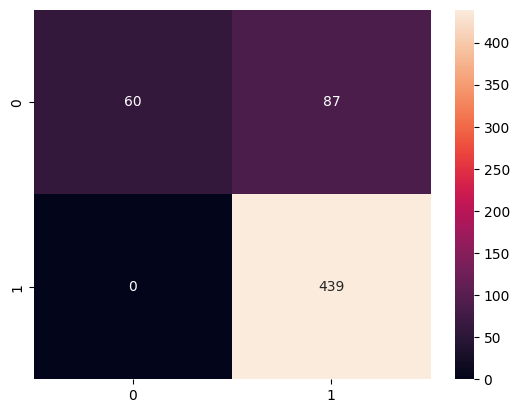

[[ 60  87]
 [  0 439]]
recall :  1.0
precision :  0.8346007604562737
f1score :  0.9098445595854923


In [43]:
y_pred = model.predict(testx)

y_pred_label = np.round(y_pred).astype(int)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label)
precision = precision_score(testy, y_pred_label)
f1score = f1_score(testy, y_pred_label)
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

#### Tentative Validation curve

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [49]:
def create_model():
    num_classes = 1
    core_size = 6

    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(64, core_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, core_size, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(256, core_size, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(512, core_size, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return model


In [53]:
use_all_dataset()

datasetX = datasetX.astype('float32') / 255.0
datasetY = np.array([0 if y == "NORMAL" else 1 for y in datasetY]).astype('int')

Training fold 1 ...
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 797s 5s/step - loss: 1.1840 - precision_10: 0.8242 - recall_11: 0.8716 - val_loss: 0.6292 - val_precision_10: 0.7440 - val_recall_11: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 800s 5s/step - loss: 0.1671 - precision_10: 0.9560 - recall_11: 0.9599 - val_loss: 0.2946 - val_precision_10: 0.8382 - val_recall_11: 0.9977
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - loss: 0.1740 - precision_10: 0.9507 - recall_11: 0.9622 - val_loss: 0.1960 - val_precision_10: 0.9132 - val_recall_11: 0.9897
Score for fold 1: loss of 0.19604668021202087; precision of 0.9896789193153381; recall of 0.9132274985313416
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


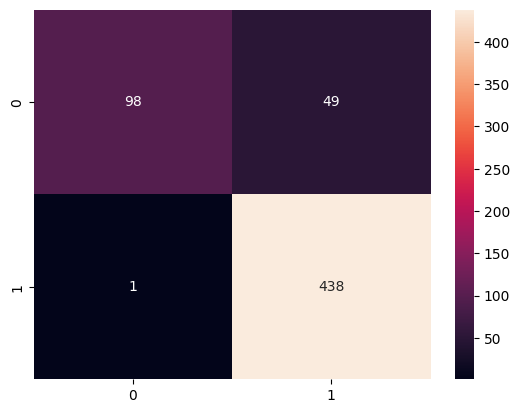

[[ 98  49]
 [  1 438]]
recall :  0.9977220956719818
precision :  0.8993839835728953
f1score :  0.9460043196544277
Training fold 2 ...
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 804s 5s/step - loss: 0.9474 - precision_11: 0.8314 - recall_12: 0.9155 - val_loss: 0.4889 - val_precision_11: 0.7387 - val_recall_12: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 781s 5s/step - loss: 0.1569 - precision_11: 0.9558 - recall_12: 0.9678 - val_loss: 0.3365 - val_precision_11: 0.7696 - val_recall_12: 1.0000
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 782s 5s/step - loss: 0.1426 - precision_11: 0.9606 - recall_12: 0.9688 - val_loss: 0.2431 - val_precision_11: 0.8735 - val_recall_12: 0.9977
Score for fold 2: loss of 0.2431463897228241; precision of 0.9976878762245178; recall of 0.873481810092926
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


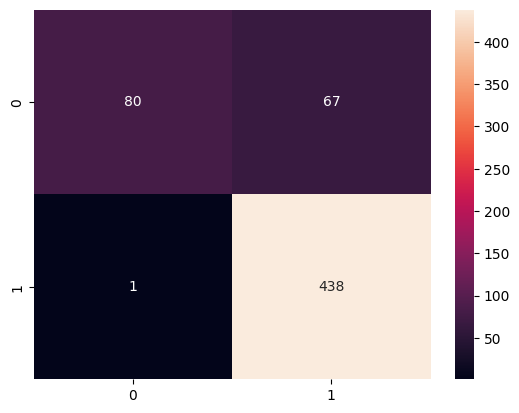

[[ 80  67]
 [  1 438]]
recall :  0.9977220956719818
precision :  0.8673267326732673
f1score :  0.9279661016949152
Training fold 3 ...
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 786s 5s/step - loss: 2.1781 - precision_12: 0.7626 - recall_13: 0.9431 - val_loss: 0.7641 - val_precision_12: 0.7233 - val_recall_13: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 781s 5s/step - loss: 0.2273 - precision_12: 0.9290 - recall_13: 0.9619 - val_loss: 0.7721 - val_precision_12: 0.7233 - val_recall_13: 1.0000
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 791s 5s/step - loss: 0.1833 - precision_12: 0.9480 - recall_13: 0.9535 - val_loss: 0.3283 - val_precision_12: 0.8238 - val_recall_13: 0.9988
Score for fold 3: loss of 0.32830873131752014; precision of 0.9988193511962891; recall of 0.8237585425376892
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


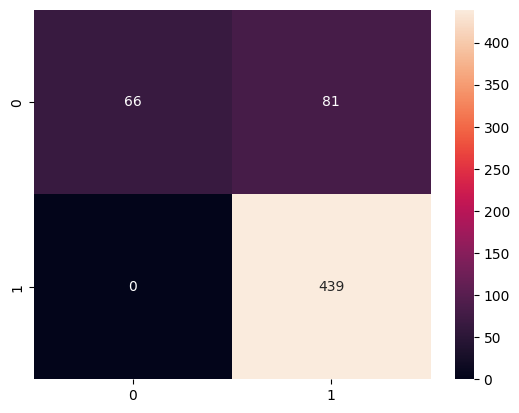

[[ 66  81]
 [  0 439]]
recall :  1.0
precision :  0.8442307692307692
f1score :  0.9155370177267987
Training fold 4 ...
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - loss: 1.2329 - precision_13: 0.8638 - recall_14: 0.9048 - val_loss: 0.5073 - val_precision_13: 0.7340 - val_recall_14: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 799s 5s/step - loss: 0.1665 - precision_13: 0.9593 - recall_14: 0.9681 - val_loss: 0.3319 - val_precision_13: 0.8924 - val_recall_14: 0.9952
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 822s 6s/step - loss: 0.1288 - precision_13: 0.9648 - recall_14: 0.9760 - val_loss: 0.1711 - val_precision_13: 0.9653 - val_recall_14: 0.9782
Score for fold 4: loss of 0.17110134661197662; precision of 0.9781818389892578; recall of 0.9653109908103943
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


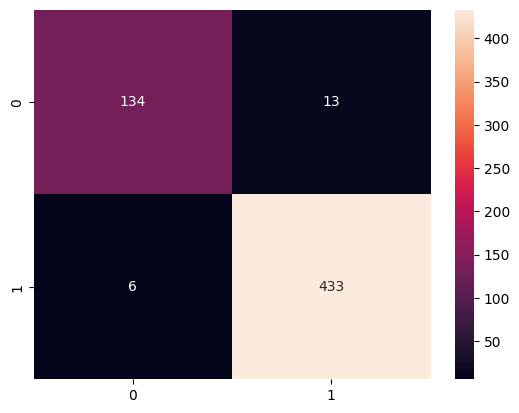

[[134  13]
 [  6 433]]
recall :  0.9863325740318907
precision :  0.9708520179372198
f1score :  0.9785310734463277
Training fold 5 ...
Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 769s 5s/step - loss: 1.5158 - precision_14: 0.7728 - recall_15: 0.9374 - val_loss: 0.6803 - val_precision_14: 0.7378 - val_recall_15: 1.0000
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 771s 5s/step - loss: 0.2516 - precision_14: 0.9216 - recall_15: 0.9392 - val_loss: 0.4906 - val_precision_14: 0.7378 - val_recall_15: 1.0000
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - loss: 0.1791 - precision_14: 0.9444 - recall_15: 0.9608 - val_loss: 0.3474 - val_precision_14: 0.8037 - val_recall_15: 1.0000
Score for fold 5: loss of 0.3474045395851135; precision of 1.0; recall of 0.8037209510803223
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


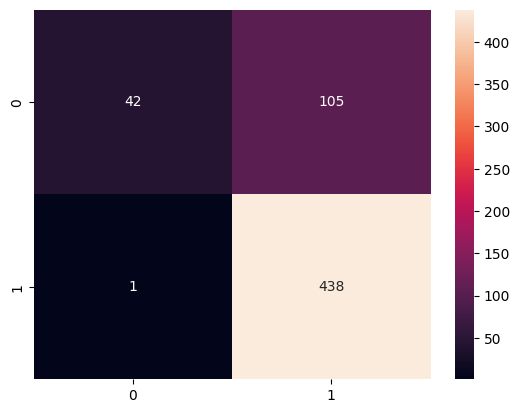

[[ 42 105]
 [  1 438]]
recall :  0.9977220956719818
precision :  0.8066298342541437
f1score :  0.8920570264765784


In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # Vous pouvez ajuster le nombre de folds

fold_no = 1
for train_index, val_index in kf.split(datasetX):
    print(f'Training fold {fold_no} ...')
    
    # Split data
    trainx, xval = datasetX[train_index], datasetX[val_index]
    trainy, yval = datasetY[train_index], datasetY[val_index]

    # Créer un nouveau modèle pour ce fold
    model = create_model()

    # Entraîner le modèle
    history = model.fit(trainx, trainy, validation_data=(xval, yval), epochs=3)
    
    # Évaluer le modèle
    scores = model.evaluate(xval, yval, verbose=0)
    
    print(f'Score for fold {fold_no}: loss of {scores[0]}; precision of {scores[1]}; recall of {scores[2]}')

    y_pred = model.predict(testx)

    y_pred_label = np.round(y_pred).astype(int)

    cm = confusion_matrix(testy, y_pred_label)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

    print(cm)
    recall = recall_score(testy, y_pred_label)
    precision = precision_score(testy, y_pred_label)
    f1score = f1_score(testy, y_pred_label)
    print("recall : ", recall)
    print("precision : ", precision)
    print("f1score : ", f1score)
    
    fold_no += 1
